In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


#from keras.layers import Dense, Input
#from keras.models import Model

#import omnifold6b as of

#import tensorflow as tf

#import simple_pdf2b as simple_pdf


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
#print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]






#--- perfect
#resolution = [ 0.000001  ]

#--- very good
#resolution = [ 0.05  ]

#--- good
#resolution = [ 0.25  ]

#--- nominal
#resolution = [ 0.5  ]

#--- medium poor
resolution = [ 0.75  ]

#--- poor
#resolution = [ 1.0  ]







train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






ngen_train = 100000
ngen_true =   10000

#ngen_train = 1000000
#ngen_true =   100000

of_niter = 5





do_bootstrap = False

n_boot_samples = 500



ds_input_dir = 'toy-study6b-1d-1a-10k'


output_dir = 'hist-pdf-toy-study-1d-2a-save-hist-only-0.5k-mediumbad'

#save_step2_model = True



hist_low = -10.
hist_high = 10.

hist_nbins = 1000


hist_binwidth = (hist_high - hist_low) / hist_nbins

window_dx = 0.3

window_nbins = int( window_dx / hist_binwidth )

print(' window_nbins : %d' % window_nbins)

hist_pars = {}
hist_pars['low']  = hist_low
hist_pars['high'] = hist_high
hist_pars['nbins'] = hist_nbins
hist_pars['binwidth'] = hist_binwidth
hist_pars['window_dx'] = window_dx
hist_pars['window_nbins'] = window_nbins


output_hist_low = -3.
output_hist_high = 3.
output_hist_nbins = 20






 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100
 window_nbins : 15


In [4]:
hist_pars

{'low': -10.0,
 'high': 10.0,
 'nbins': 1000,
 'binwidth': 0.02,
 'window_dx': 0.3,
 'window_nbins': 15}

In [5]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [6]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [7]:
train_cov_inv = np.linalg.inv( train_cov )

In [8]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [9]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [10]:
true_cov_inv = np.linalg.inv( true_cov )

In [11]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [12]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [13]:

#--- Read the datasets instead of generating new ones.

train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )



#with open('%s/train-and-true-samples.npy' % ds_input_dir, 'rb') as f :
#    train_pts = np.load(f)
#    train_det_pts = np.load(f)
#    true_pts = np.load(f)
#    true_det_pts = np.load(f)

print('\n\n train_pts:')
print( train_pts )
print('\n\n')
print(' train_pts shape:  %s' % str(train_pts.shape))

train_both = np.stack([train_pts, train_det_pts], axis=1)
    
#-- ok to regenerate these (just for plots)
true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights




 train_pts:
[[ 0.74034239]
 [-1.5817524 ]
 [ 0.08755293]
 ...
 [ 1.24407596]
 [ 0.56298109]
 [ 0.51251956]]



 train_pts shape:  (100000, 1)


In [14]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [15]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [16]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )



config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )

config_file.write('\n\n')
config_file.write('output_hist_low : %s\n' % str(output_hist_low))
config_file.write('output_hist_high : %s\n' % str(output_hist_high))
config_file.write('output_hist_nbins : %s\n' % str(output_hist_nbins))

config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : hist-pdf-toy-study-1d-2a-save-hist-only-0.5k-mediumbad/config.txt

2024-08-01 16:13:13.409681

ngen_train 100000
ngen_true  10000
of_niter   5
ndim       1


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [0.75]


output_hist_low : -3.0
output_hist_high : 3.0
output_hist_nbins : 20





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

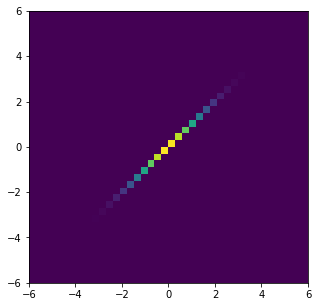

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

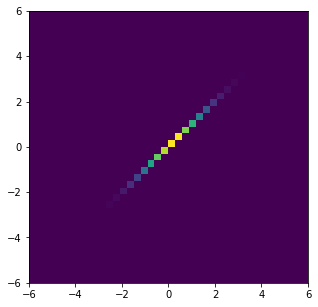

In [18]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

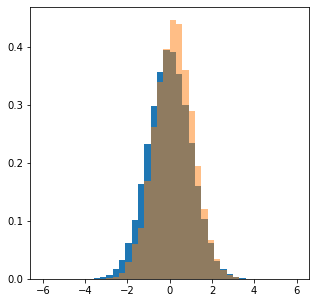

In [19]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [20]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[ 0.74034239]
 [-1.5817524 ]
 [ 0.08755293]
 ...
 [ 1.24407596]
 [ 0.56298109]
 [ 0.51251956]]


In [21]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[ 0.54034239]
 [-1.7817524 ]
 [-0.11244707]
 ...
 [ 1.04407596]
 [ 0.36298109]
 [ 0.31251956]]


In [22]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [23]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [24]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [25]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [26]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [27]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [28]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [29]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [30]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.42894852 0.16148625 0.56203132 ... 0.26022011 0.48150494 0.4947498 ]


In [31]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.52349241 0.08833139 0.62200349 ... 0.31985026 0.57791132 0.59020012]


In [32]:
pdf_ratio = pdf_true / pdf_train

In [33]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [34]:
calc_weight = pdf_ratio

In [35]:
calc_weight_scaled = sample_sf * pdf_ratio

In [36]:
with open( '%s/analytic-weights.npy' % output_dir, 'wb') as f :
    np.save(f, calc_weight_scaled)

## Define function for calculating model pars (mean and cov) from weighted events

In [37]:
def calc_mean_cov( weights, fi1, fi2, sample_points ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * sample_points[:,fi1] )
    wx2 = np.sum( weights * sample_points[:,fi2] )
    wx1x2 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi1] )
        wx2x2 = np.sum( weights * sample_points[:,fi2] * sample_points[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [38]:
weights_true = np.ones( ngen_true )

In [39]:
true_calc_mean = np.zeros( ndim )
true_calc_cov = np.ones( shape=(ndim,ndim) )

In [40]:
for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        rd = calc_mean_cov( weights_true, fi1, fi2, true_pts )
        true_calc_mean[fi1] = rd['mean_x1']
        true_calc_cov[fi1,fi2] = rd['cov_x1x2']

In [41]:
for fi1 in range(ndim) :
    print('  mean f%d :  %7.3f' % (fi1, true_calc_mean[fi1]))
    for fi2 in range(fi1,ndim) :
        print('  cov f%df%d :  %7.4f' % (fi1,fi2, true_calc_cov[fi1,fi2]))
        if fi1 == fi2 :
            print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(true_calc_cov[fi1,fi1])))
        

  mean f0 :    0.204
  cov f0f0 :   0.8044
  sigma f0 :   0.8969


In [42]:
print( true_pts.shape )
print( true_pts.shape[1])

(10000, 1)
1


In [43]:
def calc_model_pars( weights, sample_points, verbose=0 ) :
    
    return_dict = {}
    
    ndim = sample_points.shape[1]
    if verbose : print(' ndim = %d' % ndim )
    
    model_mean = np.zeros( ndim )
    model_cov = np.ones( shape=(ndim,ndim) )
    
    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            rd = calc_mean_cov( weights, fi1, fi2, sample_points )
            model_mean[fi1] = rd['mean_x1']
            model_cov[fi1,fi2] = rd['cov_x1x2']    
            if verbose and fi2==fi1 : print('  mean f%d :  %7.3f' % (fi1, model_mean[fi1]))
            if verbose : print('  cov f%df%d :  %7.4f' % (fi1,fi2, model_cov[fi1,fi2]))
            if verbose and fi2==fi1 : print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(model_cov[fi1,fi1])))
   
    for fi2 in range(ndim) :
        for fi1 in range(fi2+1,ndim) :
            model_cov[fi1,fi2] = model_cov[fi2,fi1]
    
    return_dict['mean'] = model_mean
    return_dict['cov']  = model_cov
    
    return return_dict


In [44]:
test_calc_true_model = calc_model_pars( weights_true, true_pts, 1)

 ndim = 1
  mean f0 :    0.204
  cov f0f0 :   0.8044
  sigma f0 :   0.8969


In [45]:
test_calc_true_model

{'mean': array([0.20425301]), 'cov': array([[0.8044011]])}

## Define function to calculate the reweighting factor (pdf2/pdf1).

In [46]:
def calc_pdf_ratio( model1_mu, model2_mu, model1_cov, model2_cov, sample_points ) :
    
    ndim = len(model1_mu)
    
    pts_minus_mu1 = sample_points - model1_mu
    pts_minus_mu2 = sample_points - model2_mu
    
    cov1_inv = np.linalg.inv( model1_cov )
    cov2_inv = np.linalg.inv( model2_cov )
    
    cov1_det = np.linalg.det( model1_cov )
    cov2_det = np.linalg.det( model2_cov )
    
    cov1_inv_times_v1 = np.tensordot( cov1_inv, pts_minus_mu1.T, axes=(1,0) )
    cov2_inv_times_v2 = np.tensordot( cov2_inv, pts_minus_mu2.T, axes=(1,0) )
    
    v1_times_cov1_inv_times_v1 =  np.sum( pts_minus_mu1.T * cov1_inv_times_v1, axis=0)
    v2_times_cov2_inv_times_v2 =  np.sum( pts_minus_mu2.T * cov2_inv_times_v2, axis=0)
    
    exp_v1_times_cov1_inv_times_v1 = np.exp( -0.5 * v1_times_cov1_inv_times_v1 )
    exp_v2_times_cov2_inv_times_v2 = np.exp( -0.5 * v2_times_cov2_inv_times_v2 )
    
    norm2_model1 = np.power( 3.14159265, ndim) * cov1_det
    norm2_model2 = np.power( 3.14159265, ndim) * cov2_det
    
    pdf1 = exp_v1_times_cov1_inv_times_v1 / np.sqrt(norm2_model1)
    pdf2 = exp_v2_times_cov2_inv_times_v2 / np.sqrt(norm2_model2)
    
    pdf_ratio = pdf1 / pdf2
    
    return pdf_ratio
    
    

In [47]:
test_calc_pdf_ratio = calc_pdf_ratio( true_mu, train_mu, true_cov, train_cov, train_pts )

In [48]:
test_calc_pdf_ratio

array([1.22040847, 0.54699015, 1.1067061 , ..., 1.22915274, 1.2002189 ,
       1.19292644])

In [49]:
pdf_ratio

array([1.22040847, 0.54699015, 1.1067061 , ..., 1.22915274, 1.2002189 ,
       1.19292644])

## Function that estimates the pdf from a histogram (multi-bin sum)

In [50]:

#-- computes pdf2/pdf1 at location of points1
#
#    for OmniFold step 1, points2 is the data, points1 is the MC
#

def pdf_ratio_from_hist( points1, points2, weights1, weights2, hist_pars, verbose=0 ) :
    
    ndim = points1.shape[1]
    
    if ndim > 1 :
        print('\n\n *** Only 1D supported for now.\n\n')
        sys.exit()
        
    hist_low = hist_pars['low']
    hist_high = hist_pars['high']
    hist_nbins = hist_pars['nbins']
    hist_binwidth = hist_pars['binwidth']
    
    
    nph1 = np.histogram( points1[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights1 )
    nph2 = np.histogram( points2[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights2 )
    
    hist_pdf1 = np.zeros(hist_nbins)
    hist_pdf2 = np.zeros(hist_nbins)

    for bi in range( hist_nbins ) :
        bilow = bi - window_nbins
        bihigh = bi + window_nbins
        if bilow < 0 : bilow = 0
        if bihigh >= hist_nbins : bihigh = hist_nbins-1

        hist_pdf1[bi] = np.sum( nph1[0][bilow: bihigh] )
        hist_pdf2[bi] = np.sum( nph2[0][bilow: bihigh] )
    
    hist_pdf1_norm = hist_pdf1 / np.sum(hist_pdf1)
    hist_pdf2_norm = hist_pdf2 / np.sum(hist_pdf2)
    
    hist_bin_indices1 = np.array(   ( (points1[:,0] - hist_low) / hist_binwidth ),   dtype=int )
    
    points1_pdf1_val = hist_pdf1_norm[ hist_bin_indices1 ]
    points1_pdf2_val = hist_pdf2_norm[ hist_bin_indices1 ]
    
    points1_pdf1_val = np.clip( points1_pdf1_val, 1.e-10, 1.e10)
    points1_pdf2_val = np.clip( points1_pdf2_val, 1.e-10, 1.e10)
    
    pdf_ratio = points1_pdf2_val / points1_pdf1_val
    
    return pdf_ratio
    

In [51]:
print('pdf_ratio shape : %s' % str(pdf_ratio.shape))

pdf_ratio shape : (100000,)


In [52]:
weights_true = np.ones( ngen_true )
weights_train = np.ones( ngen_train )

print(' train_pts shape: %s' % str(train_pts.shape))
print('  true_pts shape: %s' % str(true_pts.shape))
print(' weights_train shape: %s' % str(weights_train.shape))
print('  weights_true shape: %s' % str(weights_true.shape))

test_hist_pdf_ratio = pdf_ratio_from_hist( train_pts, true_pts, weights_train, weights_true, hist_pars )

 train_pts shape: (100000, 1)
  true_pts shape: (10000, 1)
 weights_train shape: (100000,)
  weights_true shape: (10000,)


In [53]:
pdf_ratio

array([1.22040847, 0.54699015, 1.1067061 , ..., 1.22915274, 1.2002189 ,
       1.19292644])

In [54]:
calc_weight

array([1.22040847, 0.54699015, 1.1067061 , ..., 1.22915274, 1.2002189 ,
       1.19292644])

In [55]:
test_hist_pdf_ratio

array([1.22610049, 0.57835266, 1.10201137, ..., 1.22944961, 1.23647837,
       1.21758901])

In [56]:
test_hist_pdf_ratio.shape

(100000,)

In [57]:
for pi in range(40) :
    print( ' %3d   x %7.3f   true  %7.4f  from hist %7.4f' % (pi, train_pts[pi,0], calc_weight[pi], test_hist_pdf_ratio[pi]))

   0   x   0.740   true   1.2204  from hist  1.2261
   1   x  -1.582   true   0.5470  from hist  0.5784
   2   x   0.088   true   1.1067  from hist  1.1020
   3   x  -1.097   true   0.7180  from hist  0.7078
   4   x   0.252   true   1.1451  from hist  1.1767
   5   x  -0.085   true   1.0606  from hist  1.0329
   6   x  -0.954   true   0.7698  from hist  0.7721
   7   x  -0.468   true   0.9411  from hist  0.9306
   8   x  -0.203   true   1.0262  from hist  1.0077
   9   x   0.582   true   1.2028  from hist  1.2268
  10   x   0.435   true   1.1804  from hist  1.2004
  11   x   0.591   true   1.2039  from hist  1.2268
  12   x  -1.088   true   0.7214  from hist  0.7078
  13   x  -1.630   true   0.5309  from hist  0.5836
  14   x   0.284   true   1.1518  from hist  1.1820
  15   x   0.333   true   1.1617  from hist  1.1840
  16   x  -0.884   true   0.7950  from hist  0.8101
  17   x  -1.298   true   0.6456  from hist  0.6130
  18   x  -0.039   true   1.0734  from hist  1.0526
  19   x  -0

## Define OmniFold implementation with fit pdf

In [58]:
def hist_pdf_omnifold1a( theta0, theta_unknown_S, iterations, verbose=0 ) :
    
    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    ngen_train = len(theta0)
    ngen_true  = len(theta_unknown_S)
    ndim = theta0_G.shape[1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))


    neval_train = ngen_train
    neval_true  = ngen_true


    if verbose :
        print("\n\n")
        print("  ======== simple_pdf2b\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) )
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) )
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) )
        print("\n  iterations = %d\n" % iterations )
        print("  ndim : %d" % ndim )
        print("  neval_train : %d" % neval_train )
        print("  neval_true  : %d" % neval_true )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    sample_norm_sf = ( (1.*neval_train)/(1.*neval_true) ) *  ( (1.*ngen_true)/(1.*ngen_train) )
    
    
    if verbose :
        print('\n\n Calculating model pars for data or true (theta_unknown_S)')
        
    
    #model_pars_theta_unknown_S = calc_model_pars( np.ones( ngen_true ), theta_unknown_S, verbose )
    
    
    
    
    
    
    return_dict = {}
    
    for i in range(iterations):
    
        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            
        if (verbose>0):
            print("   -- ITERATION %d  STEP 1\n" % (i+1) )
            
        print(" weights_push at the beginning")
        print( weights_push )

        
        #model_pars_theta0_S = calc_model_pars( weights_push, theta0_S, verbose )
        
        #pdf_ratio_step1 = calc_pdf_ratio( model_pars_theta_unknown_S['mean'],
        #                           model_pars_theta0_S['mean'],
        #                           model_pars_theta_unknown_S['cov'],
        #                           model_pars_theta0_S['cov'],
        #                           theta0_S )

        pdf_ratio_step1 = pdf_ratio_from_hist( theta0_S, 
                                              theta_unknown_S, 
                                              weights_push, 
                                              np.ones( ngen_true ),
                                              hist_pars
                                             )
        if verbose>0 :
            print(' pdf_ratio_step1:  shape %s ' % str(pdf_ratio_step1.shape))
            print(pdf_ratio_step1)
        
        
        step1_output_weights = sample_norm_sf * pdf_ratio_step1

        weights_pull = weights_push * step1_output_weights
        
        if verbose>0 :
            print("  iter %d, step1_output_weights:  shape %s" % (i+1, str(step1_output_weights.shape)))
            print(step1_output_weights)


        weights[i, :1, :] = step1_output_weights


            
            

        if (verbose>0):
            print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
            
        #if verbose : print(' calculation of model pars with push weights')
        #model_pars_theta0_G_push_weight = calc_model_pars( weights_push, theta0_G, verbose )

        #if verbose : print(' calculation of model pars with pull weights')
        #model_pars_theta0_G_pull_weight = calc_model_pars( weights_pull, theta0_G, verbose )
        
        #pdf_ratio_step2 = calc_pdf_ratio( model_pars_theta0_G_pull_weight['mean'],
        #                           model_pars_theta0_G_push_weight['mean'],
        #                           model_pars_theta0_G_pull_weight['cov'],
        #                           model_pars_theta0_G_push_weight['cov'],
        #                           theta0_G )        

        
        pdf_ratio_step2 = pdf_ratio_from_hist( theta0_G, 
                                              theta0_G, 
                                              weights_push, 
                                              weights_pull,
                                              hist_pars
                                             )
        
        
        step2_output_weights = pdf_ratio_step2
        
        weights_push = weights_push * step2_output_weights
        
        push_weights_for_output[i] = weights_push
        
        weights[i, 1:2, :] = step2_output_weights
        
        if verbose>0 :
           print("  iter %d, step2_output_weights:" % (i+1))
           print(step2_output_weights)
        
    return_dict["weights"] = weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["final_push_weights"] = weights_push

    return return_dict
            
            

In [59]:
rd = hist_pdf_omnifold1a( train_both, true_det_pts, of_niter, 1 )




  ======== simple_pdf2b


  shape of theta0_S : (100000, 1)
  shape of theta0_G : (100000, 1)
  shape of theta_unknown_S : (10000, 1)

  iterations = 5

  ndim : 1
  neval_train : 100000
  neval_true  : 10000





 Calculating model pars for data or true (theta_unknown_S)

ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 pdf_ratio_step1:  shape (100000,) 
[1.14203058 0.78774206 1.10219495 ... 1.13802559 1.04371585 1.05137205]
  iter 1, step1_output_weights:  shape (100000,)
[1.14203058 0.78774206 1.10219495 ... 1.13802559 1.04371585 1.05137205]

   -- ITERATION 1  STEP 2

  iter 1, step2_output_weights:
[1.10326298 0.7521276  1.04390116 ... 1.13367201 1.08923247 1.08426708]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[1.10326298 0.7521276  1.04390116 ... 1.13367201 1.08923247 1.08426708]
 pdf_ratio_step1:  shape (100000,) 
[1.05804234 0.88195388 1.03858516 ... 1.05933937 1.04799086 1.02350838]
  iter 2, ste

In [60]:
of_weights = rd["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = rd["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = rd["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


<function matplotlib.pyplot.show(close=None, block=None)>

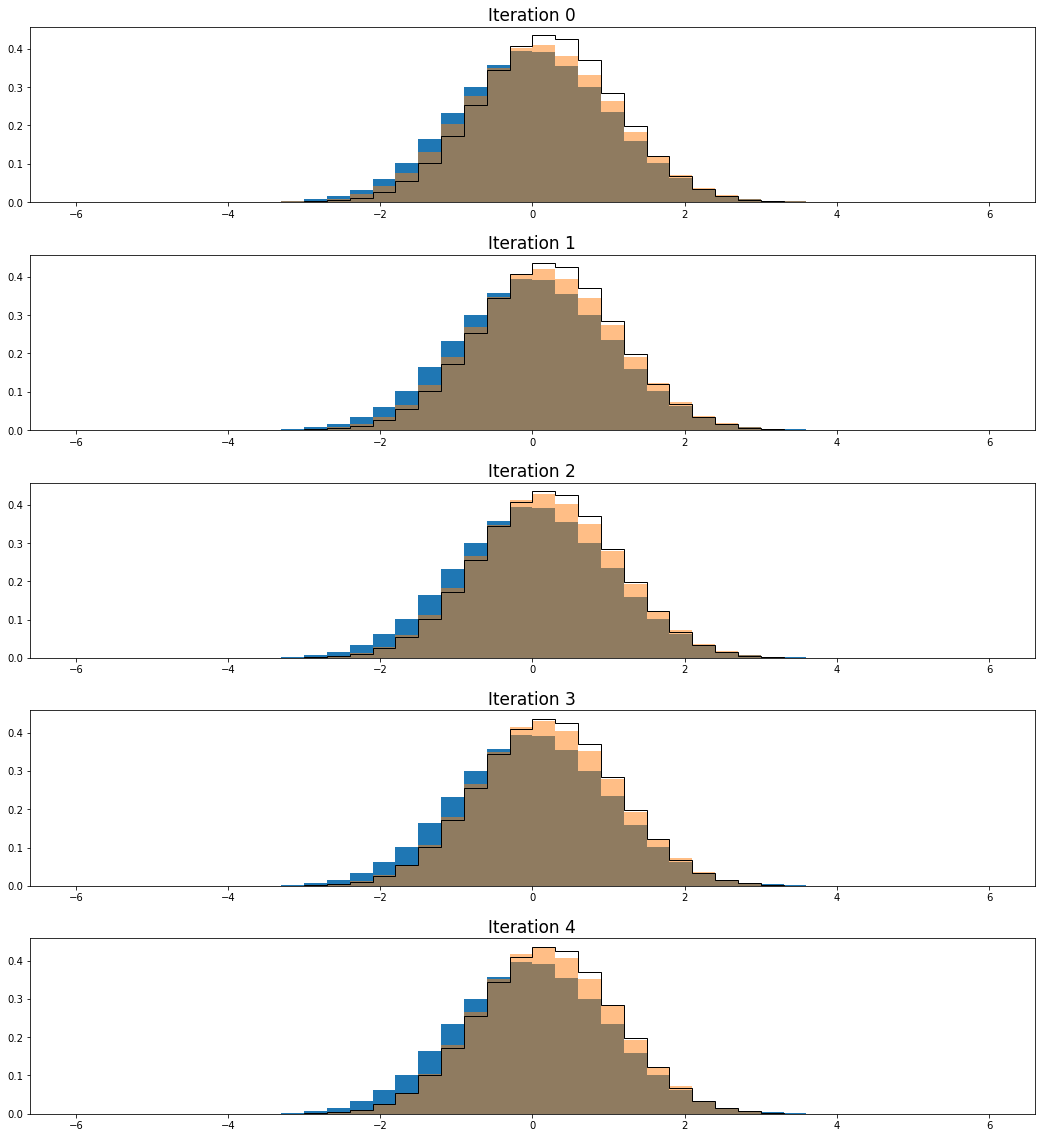

In [61]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [62]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

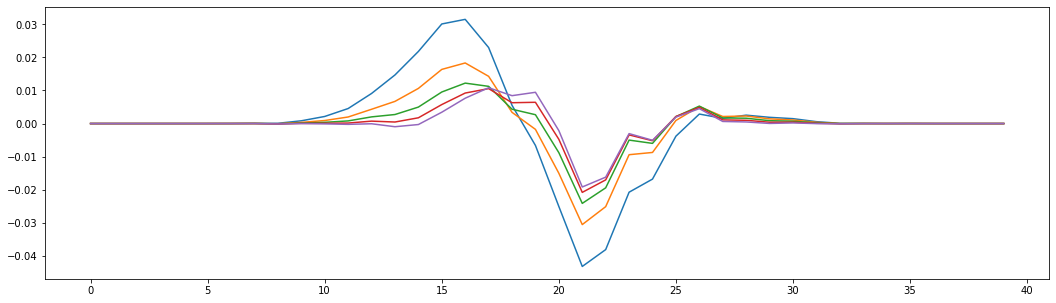

In [63]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

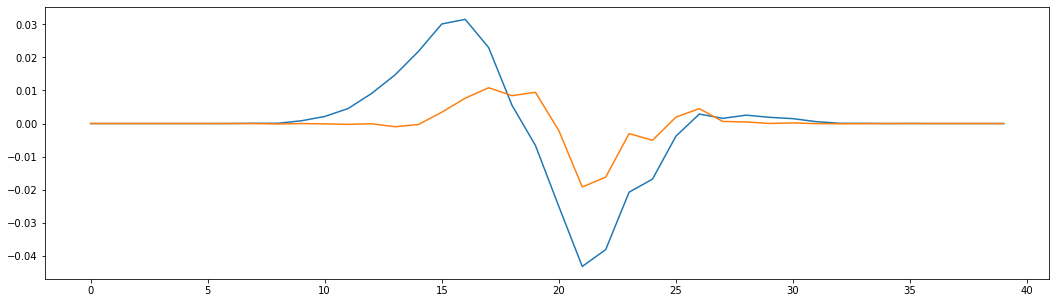

In [64]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

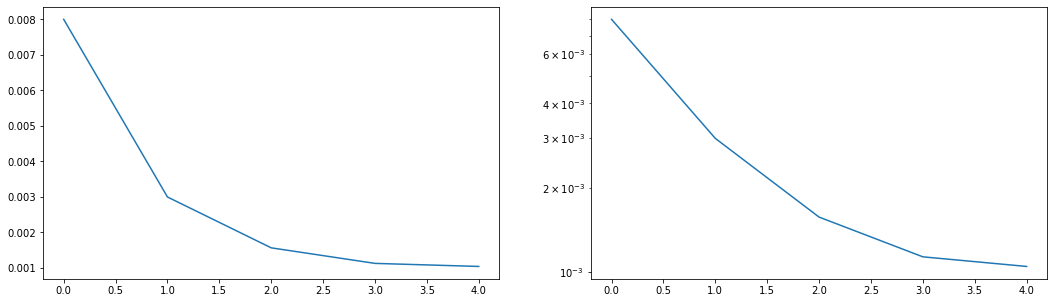

In [65]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

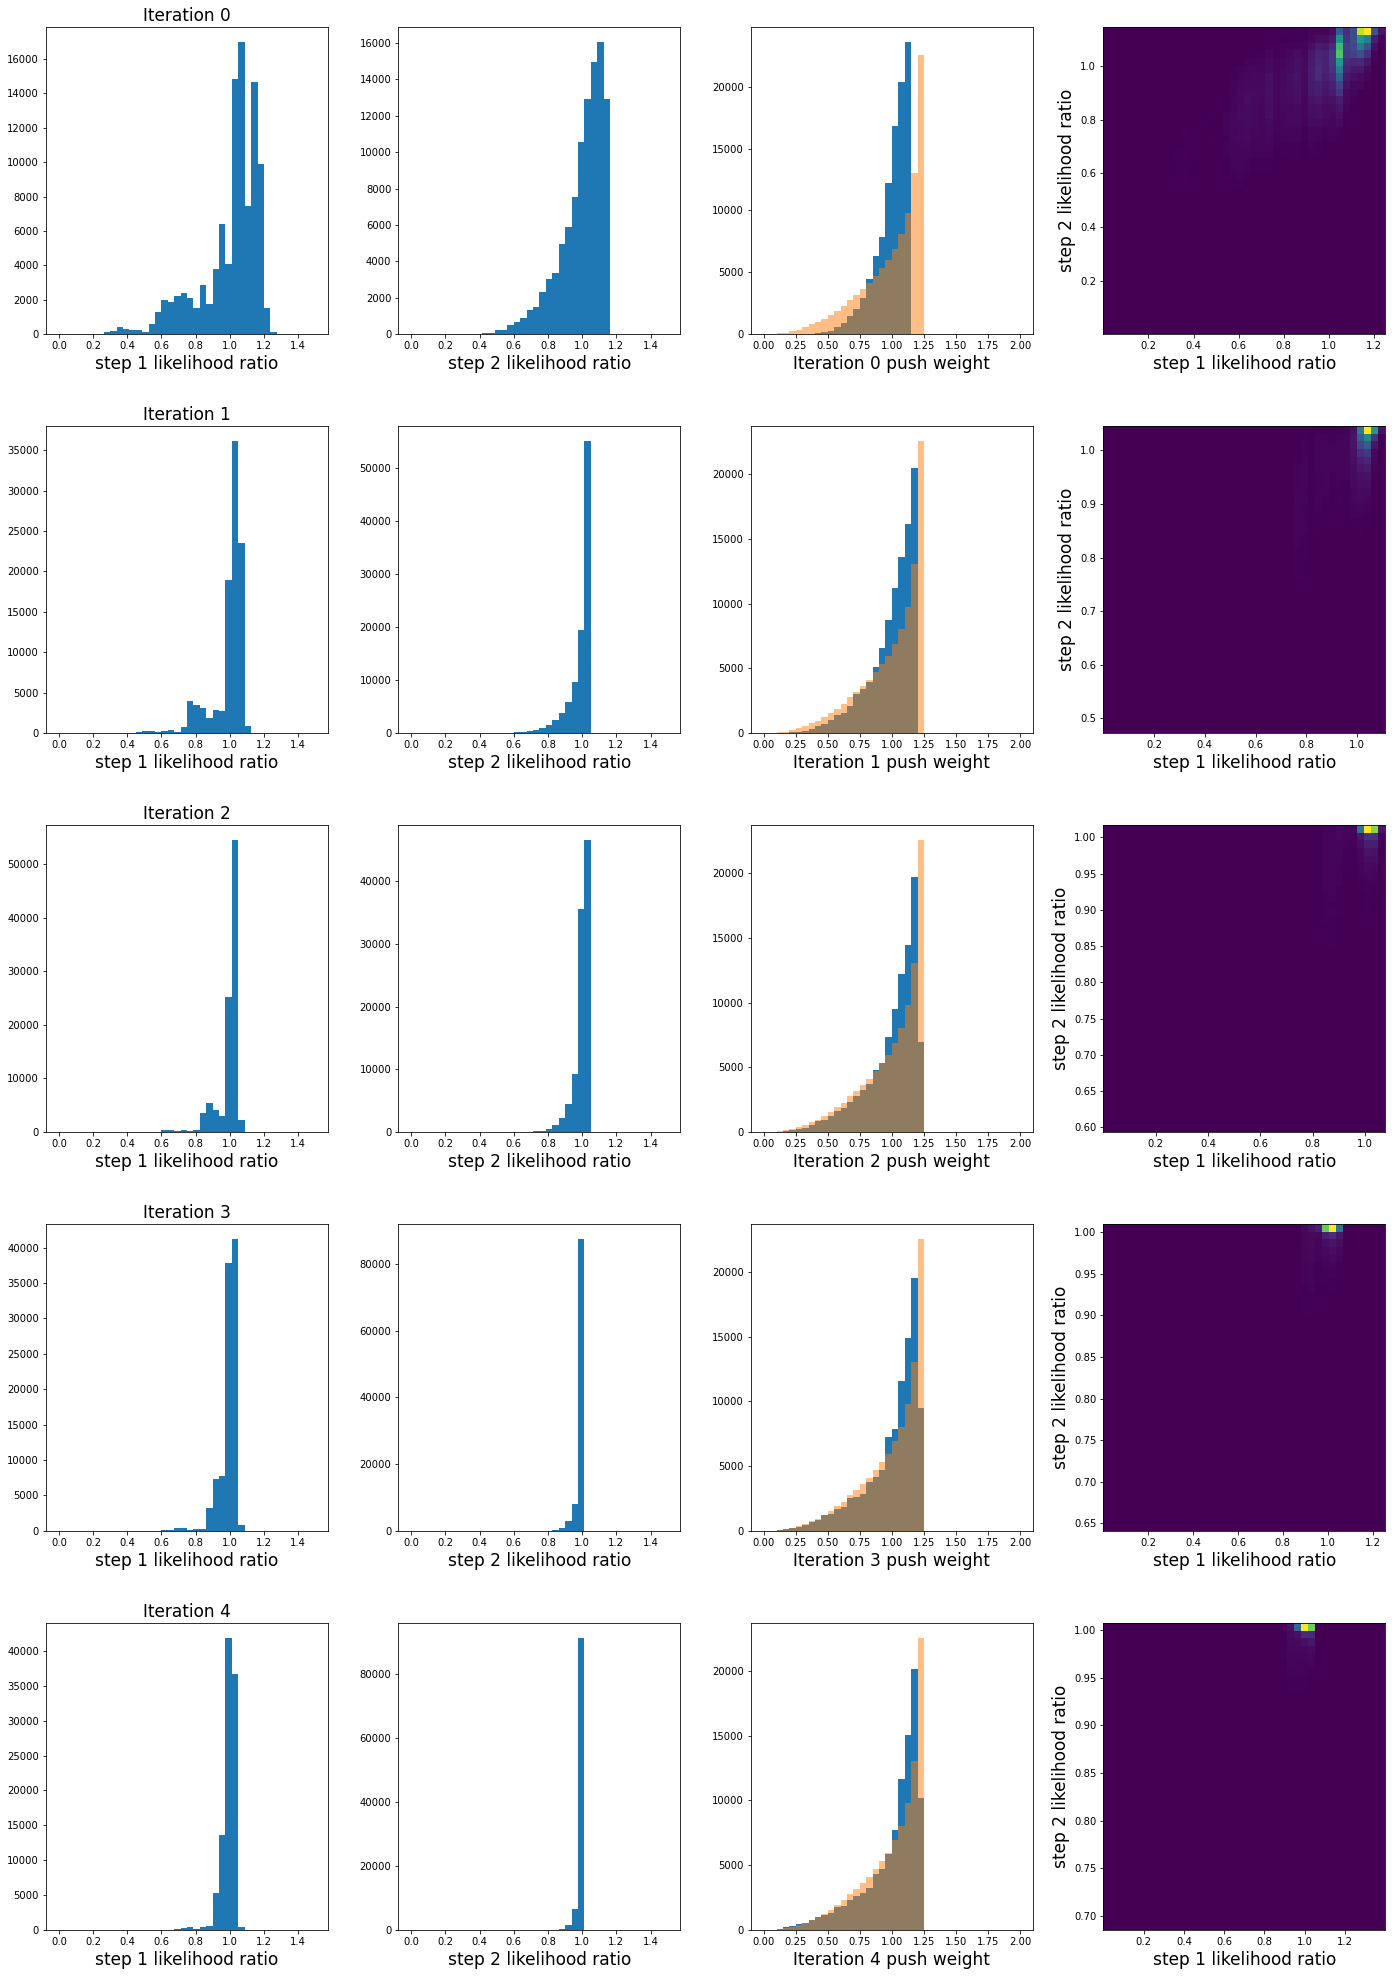

In [66]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

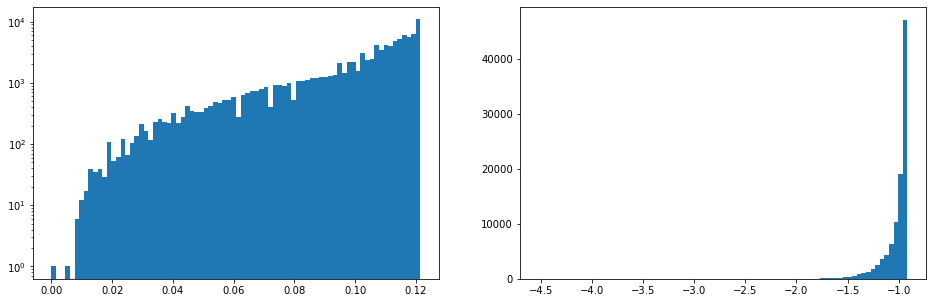

In [67]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

final_push_weights_scaled = np.clip( final_push_weights_scaled, 1e-11, 1e11)

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

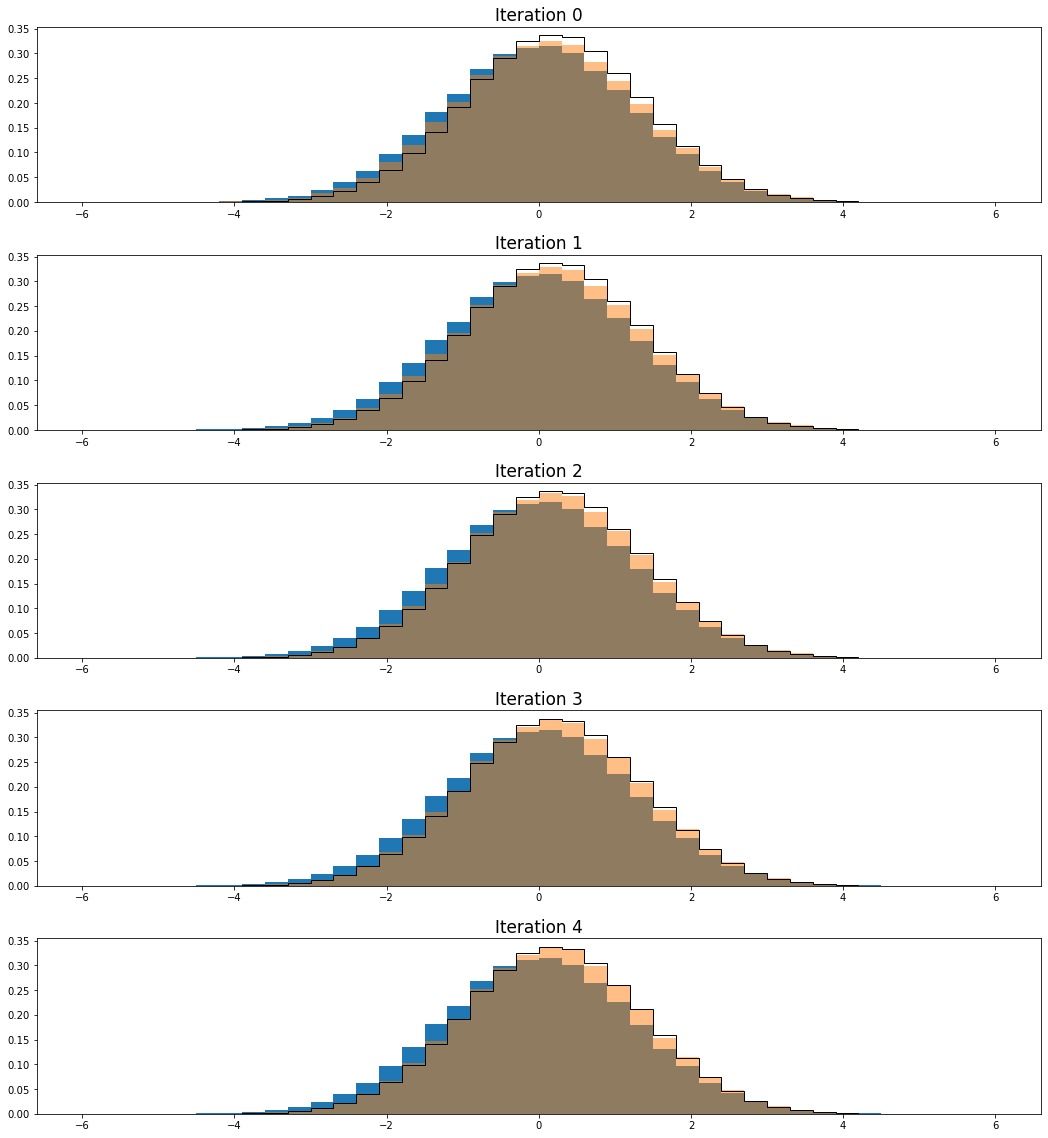

In [68]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [69]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

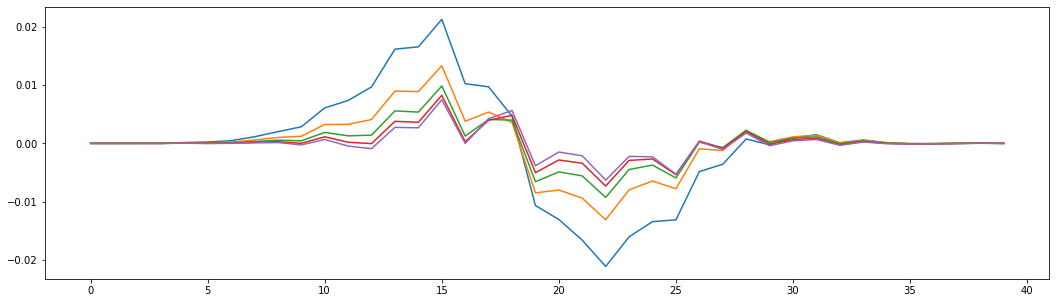

In [70]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

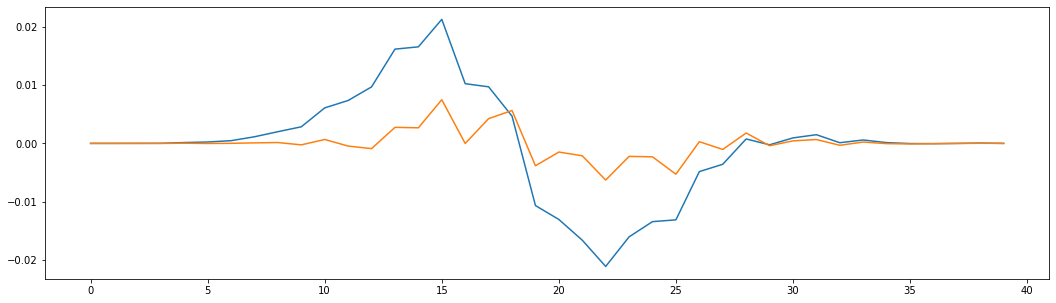

In [71]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

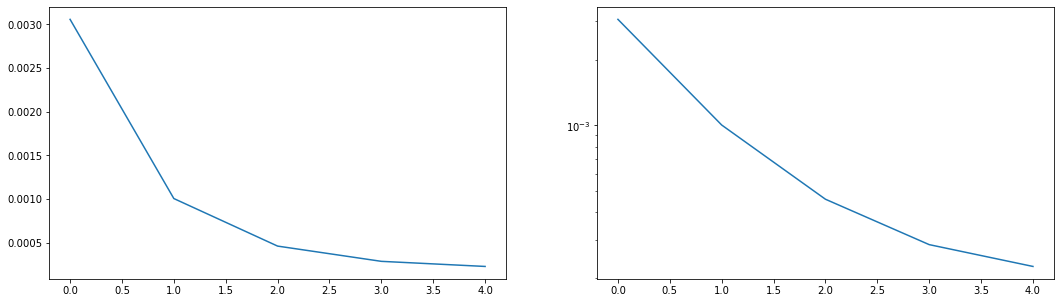

In [72]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [73]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.000  rms 0.174      step 2 mean  1.000  rms 0.127
  iter  1 : step 1 mean  0.992  rms 0.100      step 2 mean  0.992  rms 0.066
  iter  2 : step 1 mean  0.994  rms 0.068      step 2 mean  0.994  rms 0.039
  iter  3 : step 1 mean  0.996  rms 0.054      step 2 mean  0.996  rms 0.025
  iter  4 : step 1 mean  0.997  rms 0.046      step 2 mean  0.997  rms 0.018


<function matplotlib.pyplot.show(close=None, block=None)>

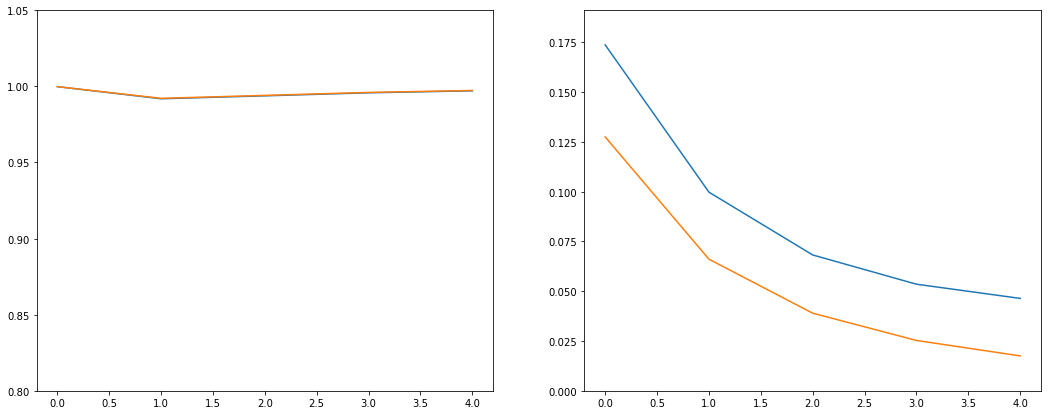

In [74]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

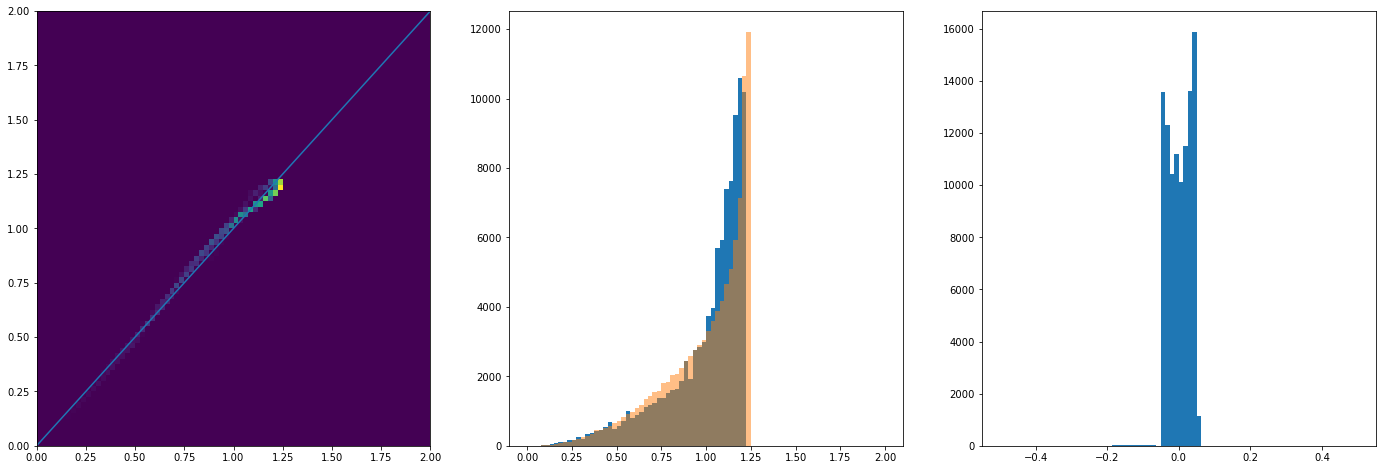

In [75]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [76]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.03062




In [77]:
output_histograms = np.zeros( shape=(n_boot_samples, output_hist_nbins) )

In [78]:

verbose = False



import gc

In [79]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        #print("\n Creating bootstrap sample %3d" % bi )
        #boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        fname = "%s/bootstrap-points-%03d.npy" % (ds_input_dir, bi)
        print('\n Reading bootstrap sample from file: %s' % fname )
        with open( fname, 'rb' ) as f :
            boot_true_det_pts = np.load(f)
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        

        
#    boot_of_return_dict = of.omnifold6b( 
#        train_both, boot_true_det_pts, of_niter, model, verbose, 
#        batch_size_setval, learning_rate_setval, epochs_setval )

#    rd = simple_pdf.simple_pdf2b( train_both, boot_true_det_pts, 
#                             train_train_det_within_sphere, train_train_gen_within_sphere,
#                             of_niter, radius, norm_radius2, False, False )

#    rd = fit_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    rd = hist_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    
    
    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = rd["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

    this_output_hist, this_output_hist_binning = np.histogram( train_pts[:,0], 
                                    bins=output_hist_nbins,
                                    range=[output_hist_low, output_hist_high],
                                    density=False,
                                    weights=boot_final_push_weights_scaled 
                                   )
    
    output_histograms[bi,:] = this_output_hist 
    
    #with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
    #    np.save( f, boot_final_push_weights_scaled )
        
    del boot_final_push_weights_scaled
    del rd
    gc.collect()
    
    


 Creating toy sample   0
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11405126 0.74807645 1.04554924 ... 1.14003448 1.09862127 1.09306532]
 weights_push at the beginning
[1.16663236 0.64306166 1.07008921 ... 1.19453002 1.1457587  1.13810758]
 weights_push at the beginning
[1.1934737  0.59167374 1.08628951 ... 1.21520505 1.17124612 1.16295019]
 weights_push at the beginning
[1.20827516 0.56349351 1.09743251 ... 1.2225807  1.1860823  1.17767702]


 bootstrap 0 final push weights scaled:
[0.12169885 0.05466676 0.11050877 ... 0.12248805 0.11951431 0.11867898]

 Creating toy sample   1
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12102971 0.73167275 1.04498213 ... 1.15430788 1.10381895 1.09751709]
 weights_push at the beginning
[1.17600635 0.62238089 1.06922876 ... 1.21428732 1.15299897 1.14430658]
 weights_push at the beginning
[1.20371887 0.56953545 1.08599199 ... 1.23662747 1.17974518 1.17034173]
 we


 Creating toy sample  15
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.1167341  0.74269968 1.0438541  ... 1.1495573  1.10018775 1.09421141]
 weights_push at the beginning
[1.16913836 0.63796178 1.06705619 ... 1.20776209 1.14703388 1.13884931]
 weights_push at the beginning
[1.19504289 0.58803744 1.08263281 ... 1.22966028 1.1719774  1.16318534]
 weights_push at the beginning
[1.20872618 0.56148663 1.0936181  ... 1.23719524 1.1863293  1.1775351 ]


 bootstrap 15 final push weights scaled:
[0.12163118 0.05462384 0.11014005 ... 0.12391771 0.11950163 0.11864152]

 Creating toy sample  16
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11359488 0.74053506 1.05216252 ... 1.13514589 1.10087269 1.09616994]
 weights_push at the beginning
[1.16500218 0.6331165  1.08237518 ... 1.18381854 1.14964926 1.14370841]
 weights_push at the beginning
[1.19034079 0.58100082 1.103645   ... 1.19877339 1.176371   1.17061386]
 w


 Creating toy sample  29
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12342129 0.73645438 1.05045887 ... 1.14438126 1.10833921 1.10264413]
 weights_push at the beginning
[1.18248472 0.62826473 1.07837352 ... 1.19920155 1.16265404 1.1548335 ]
 weights_push at the beginning
[1.21415303 0.5760545  1.09740511 ... 1.21829553 1.19390998 1.18550513]
 weights_push at the beginning
[1.2327305  0.5477886  1.11109334 ... 1.22315603 1.21360641 1.20521253]


 bootstrap 29 final push weights scaled:
[0.12445071 0.05310945 0.11211059 ... 0.12224599 0.12268923 0.12187086]

 Creating toy sample  30
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12679168 0.72405985 1.04298237 ... 1.16802068 1.10712327 1.1000824 ]
 weights_push at the beginning
[1.18323503 0.61447792 1.06462255 ... 1.23448017 1.15632052 1.14648045]
 weights_push at the beginning
[1.21109206 0.56326467 1.07925509 ... 1.26008736 1.18233181 1.17154711]
 w


 Creating toy sample  43
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11744091 0.75106423 1.03796099 ... 1.15607294 1.09862627 1.09192101]
 weights_push at the beginning
[1.17049327 0.65238684 1.05687408 ... 1.21910075 1.14431636 1.13482998]
 weights_push at the beginning
[1.19720211 0.60731523 1.06928125 ... 1.24459615 1.16861125 1.15805   ]
 weights_push at the beginning
[1.21186054 0.58474668 1.07785784 ... 1.25496639 1.18272483 1.17176406]


 bootstrap 43 final push weights scaled:
[0.12205426 0.05727973 0.10837666 ... 0.12592838 0.11914652 0.11803506]

 Creating toy sample  44
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12117354 0.73496574 1.04740018 ... 1.15256189 1.10443319 1.09846664]
 weights_push at the beginning
[1.17663971 0.62636694 1.07257345 ... 1.21350099 1.15395997 1.14576271]
 weights_push at the beginning
[1.20458499 0.57404622 1.08930654 ... 1.23770677 1.18053126 1.17171124]
 w


 Creating toy sample  57
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11346689 0.75759907 1.04380193 ... 1.14215357 1.09766443 1.09204001]
 weights_push at the beginning
[1.16614444 0.65834491 1.06718732 ... 1.1996836  1.14452683 1.13673875]
 weights_push at the beginning
[1.1931037  0.6113559  1.08253963 ... 1.22311569 1.16987596 1.16141039]
 weights_push at the beginning
[1.20795128 0.58681529 1.09312744 ... 1.23279922 1.18463576 1.17607056]


 bootstrap 57 final push weights scaled:
[0.12166231 0.05731063 0.11004958 ... 0.1236987  0.11936565 0.1185193 ]

 Creating toy sample  58
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10723951 0.77148728 1.04630478 ... 1.12568006 1.09464169 1.09008028]
 weights_push at the beginning
[1.15773622 0.67813045 1.07254398 ... 1.17277309 1.14162695 1.1356462 ]
 weights_push at the beginning
[1.18413999 0.63486552 1.09036723 ... 1.18897912 1.16815116 1.16204977]
 w


 Creating toy sample  71
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11461639 0.7531707  1.04325325 ... 1.14187248 1.09863692 1.09267493]
 weights_push at the beginning
[1.16789262 0.65092169 1.0657551  ... 1.19837161 1.14591573 1.13744351]
 weights_push at the beginning
[1.19538264 0.6014288  1.08012734 ... 1.22073848 1.17158173 1.16207315]
 weights_push at the beginning
[1.21079791 0.57466555 1.08964962 ... 1.2294731  1.18665531 1.17667376]


 bootstrap 71 final push weights scaled:
[0.12201042 0.05589584 0.10958749 ... 0.12328441 0.11960184 0.11857514]

 Creating toy sample  72
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12385452 0.75064787 1.04853885 ... 1.14599638 1.10809149 1.10218392]
 weights_push at the beginning
[1.18444858 0.65032554 1.07460712 ... 1.20468393 1.16291377 1.15456159]
 weights_push at the beginning
[1.21775267 0.6042349  1.09178684 ... 1.22792658 1.19474269 1.18547594]
 w


 Creating toy sample  85
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10479171 0.75341226 1.04151652 ... 1.13563077 1.0900569  1.08488386]
 weights_push at the beginning
[1.14991086 0.65029812 1.06427543 ... 1.18605711 1.1307808  1.12397741]
 weights_push at the beginning
[1.17079024 0.59933949 1.07982667 ... 1.2033109  1.1514017  1.1444075 ]
 weights_push at the beginning
[1.18073044 0.57076632 1.09094341 ... 1.20785507 1.16243972 1.1557602 ]


 bootstrap 85 final push weights scaled:
[0.11853724 0.05530787 0.10989476 ... 0.12077625 0.11684505 0.1162218 ]

 Creating toy sample  86
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10352418 0.75809512 1.04835525 ... 1.12267077 1.09159375 1.08735098]
 weights_push at the beginning
[1.15042648 0.65294086 1.07567125 ... 1.1687846  1.13521801 1.12975307]
 weights_push at the beginning
[1.17330649 0.59889997 1.09382903 ... 1.18513692 1.15814834 1.15266784]
 w


 Creating toy sample  99
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12202056 0.74851173 1.03840778 ... 1.160053   1.1023074  1.09518163]
 weights_push at the beginning
[1.17865556 0.64814543 1.05659994 ... 1.22715274 1.15043481 1.14004659]
 weights_push at the beginning
[1.20817565 0.60181238 1.0677641  ... 1.25637215 1.17637179 1.16443226]
 weights_push at the beginning
[1.22512225 0.57823976 1.0748552  ... 1.27008733 1.19163842 1.17884189]


 bootstrap 99 final push weights scaled:
[0.12357456 0.05654451 0.10791666 ... 0.12774448 0.12012279 0.11878395]

 Creating toy sample 100
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12121461 0.74082536 1.03634001 ... 1.16741086 1.10010386 1.09282428]
 weights_push at the beginning
[1.17509665 0.63815155 1.0535238  ... 1.23703642 1.14507983 1.13470515]
 weights_push at the beginning
[1.20158809 0.59074517 1.06458454 ... 1.26676248 1.16805128 1.15642664]
 w


 Creating toy sample 113
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11003681 0.75798793 1.04213558 ... 1.14234261 1.09417517 1.08853714]
 weights_push at the beginning
[1.15929678 0.65836979 1.06415111 ... 1.19995594 1.13766626 1.12988394]
 weights_push at the beginning
[1.18318797 0.61083221 1.07834939 ... 1.22361232 1.16000042 1.15155606]
 weights_push at the beginning
[1.19532043 0.58575604 1.08790874 ... 1.2336719  1.17208005 1.1635383 ]


 bootstrap 113 final push weights scaled:
[0.12015798 0.05716076 0.1094328  ... 0.12383511 0.1178705  0.11702538]

 Creating toy sample 114
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11271009 0.75558817 1.04554042 ... 1.1356644  1.0982435  1.09298374]
 weights_push at the beginning
[1.16512044 0.65527579 1.07061654 ... 1.18660125 1.14611197 1.13900805]
 weights_push at the beginning
[1.19233368 0.60752313 1.08755071 ... 1.20424995 1.17281449 1.16528915]
 


 Creating toy sample 127
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11736824 0.73816663 1.04341481 ... 1.15440096 1.09954617 1.09331323]
 weights_push at the beginning
[1.16948939 0.63025653 1.06573406 ... 1.21721056 1.14483965 1.13617721]
 weights_push at the beginning
[1.19459715 0.57775231 1.08026275 ... 1.24320807 1.16778801 1.15832837]
 weights_push at the beginning
[1.20720376 0.54894805 1.09014376 ... 1.25441031 1.17993296 1.17030399]


 bootstrap 127 final push weights scaled:
[0.12135591 0.05316546 0.10968103 ... 0.12597346 0.11863165 0.11767297]

 Creating toy sample 128
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11598285 0.74854904 1.03644346 ... 1.15733514 1.0965672  1.08982948]
 weights_push at the beginning
[1.16723472 0.64688108 1.05365244 ... 1.22138797 1.13982617 1.13027708]
 weights_push at the beginning
[1.1921647  0.59877064 1.06434335 ... 1.24782574 1.16169764 1.15103815]
 


 Creating toy sample 141
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10520405 0.77466714 1.0368425  ... 1.13680186 1.08937096 1.08374247]
 weights_push at the beginning
[1.1526301  0.68350749 1.05573729 ... 1.19114295 1.13095525 1.12313217]
 weights_push at the beginning
[1.1761626  0.64141761 1.06785857 ... 1.21247823 1.15283116 1.1442704 ]
 weights_push at the beginning
[1.18876058 0.62023936 1.07599785 ... 1.22063521 1.16529777 1.15656029]


 bootstrap 141 final push weights scaled:
[0.11959688 0.0609016  0.10814558 ... 0.12235776 0.11728328 0.1164113 ]

 Creating toy sample 142
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10845819 0.75952811 1.04036486 ... 1.13888409 1.09254209 1.08692008]
 weights_push at the beginning
[1.15678993 0.66026477 1.06121954 ... 1.19299969 1.13507744 1.12732571]
 weights_push at the beginning
[1.18042051 0.61253816 1.07458158 ... 1.2136756  1.15705896 1.14863012]
 


 Creating toy sample 155
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12109718 0.74588419 1.04806484 ... 1.14621918 1.10569183 1.10000712]
 weights_push at the beginning
[1.17848682 0.64289447 1.07412875 ... 1.20368069 1.1580273  1.15023198]
 weights_push at the beginning
[1.20874503 0.59458361 1.09163577 ... 1.2253466  1.1876386  1.1792918 ]
 weights_push at the beginning
[1.22608079 0.56966737 1.10408279 ... 1.23255409 1.20593995 1.19765841]


 bootstrap 155 final push weights scaled:
[0.12367319 0.05560212 0.11130971 ... 0.12339733 0.12180249 0.1210029 ]

 Creating toy sample 156
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11013304 0.75018524 1.04487288 ... 1.13787501 1.09560612 1.09049763]
 weights_push at the beginning
[1.1590019  0.64740479 1.06987498 ... 1.18855627 1.14040211 1.13377019]
 weights_push at the beginning
[1.18261543 0.59790511 1.0872351  ... 1.20497562 1.1642011  1.15753411]
 


 Creating toy sample 169
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10818811 0.7493606  1.04870499 ... 1.13161098 1.09531449 1.0906977 ]
 weights_push at the beginning
[1.1565278  0.64307134 1.07621883 ... 1.18060756 1.14037927 1.1344607 ]
 weights_push at the beginning
[1.1797662  0.58987785 1.09494561 ... 1.19733274 1.16413264 1.15826005]
 weights_push at the beginning
[1.1912875  0.55983307 1.10829683 ... 1.20160255 1.17736551 1.17200915]


 bootstrap 169 final push weights scaled:
[0.11969165 0.05412288 0.11179474 ... 0.12012808 0.1184895  0.11801728]

 Creating toy sample 170
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11340142 0.75800217 1.03987769 ... 1.14892483 1.09648142 1.09055297]
 weights_push at the beginning
[1.1645493  0.66149344 1.06086198 ... 1.20822801 1.1417021  1.13361312]
 weights_push at the beginning
[1.18987023 0.6172804  1.07509985 ... 1.23117905 1.16583289 1.1572236 ]
 


 Creating toy sample 183
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11612001 0.74993201 1.04271567 ... 1.14692461 1.09979529 1.0938925 ]
 weights_push at the beginning
[1.16881909 0.64944906 1.06521861 ... 1.20317315 1.1470571  1.1389781 ]
 weights_push at the beginning
[1.19539049 0.60277763 1.08032669 ... 1.22334872 1.17276885 1.16410469]
 weights_push at the beginning
[1.2099255  0.57899415 1.0910239  ... 1.22922483 1.1880898  1.17944938]


 bootstrap 183 final push weights scaled:
[0.12184624 0.05662086 0.10986668 ... 0.12295352 0.11978728 0.11894593]

 Creating toy sample 184
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11118039 0.75458668 1.04129307 ... 1.14417173 1.09492926 1.08941559]
 weights_push at the beginning
[1.16040347 0.65436602 1.06270594 ... 1.20016264 1.13849035 1.13110175]
 weights_push at the beginning
[1.18424264 0.60678051 1.07670949 ... 1.22121881 1.16105587 1.15331788]
 


 Creating toy sample 197
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11647358 0.74504258 1.04943362 ... 1.13903126 1.10207753 1.09682229]
 weights_push at the beginning
[1.17102665 0.63866329 1.07676631 ... 1.19280724 1.1520171  1.14490014]
 weights_push at the beginning
[1.19926995 0.58653753 1.09509921 ... 1.21278912 1.1796486  1.1721003 ]
 weights_push at the beginning
[1.21502208 0.55789807 1.10799202 ... 1.21944231 1.19613867 1.18869081]


 bootstrap 197 final push weights scaled:
[0.12243531 0.05407616 0.11171613 ... 0.12209922 0.12064992 0.11993136]

 Creating toy sample 198
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10945965 0.7407556  1.04427835 ... 1.14107564 1.09431205 1.08899809]
 weights_push at the beginning
[1.15655269 0.63235205 1.06860566 ... 1.19317173 1.13698358 1.13002728]
 weights_push at the beginning
[1.17836    0.57840409 1.08535439 ... 1.21071056 1.15866149 1.15155613]
 


 Creating toy sample 211
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.1008335  0.77433254 1.03534633 ... 1.13910939 1.0843793  1.07883831]
 weights_push at the beginning
[1.14422403 0.68225581 1.053795   ... 1.19554136 1.12161603 1.11406812]
 weights_push at the beginning
[1.16396236 0.63890798 1.06598934 ... 1.21855178 1.13954687 1.13149065]
 weights_push at the beginning
[1.17296393 0.61620098 1.07451711 ... 1.2280828  1.14835472 1.14036996]


 bootstrap 211 final push weights scaled:
[0.11767254 0.0603247  0.10805648 ... 0.12321924 0.11524345 0.11447248]

 Creating toy sample 212
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.1132346  0.75440551 1.0382048  ... 1.14977809 1.0957415  1.08954843]
 weights_push at the beginning
[1.16334245 0.65666848 1.0576731  ... 1.20770372 1.13965829 1.13112162]
 weights_push at the beginning
[1.18794045 0.61185046 1.07067072 ... 1.22916706 1.16282647 1.15357982]
 


 Creating toy sample 225
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10931688 0.76506521 1.03624016 ... 1.14499436 1.09234305 1.08638421]
 weights_push at the beginning
[1.15799774 0.67169658 1.05484797 ... 1.20163294 1.13499057 1.12680459]
 weights_push at the beginning
[1.18198112 0.62926428 1.06730151 ... 1.22292973 1.15758038 1.14876158]
 weights_push at the beginning
[1.19477505 0.60822751 1.07612527 ... 1.23015089 1.17069998 1.16186755]


 bootstrap 225 final push weights scaled:
[0.120209   0.05972383 0.10824396 ... 0.12318293 0.11788765 0.11702486]

 Creating toy sample 226
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.09704984 0.77870607 1.0388284  ... 1.12367153 1.08354    1.07877712]
 weights_push at the beginning
[1.13965049 0.68665859 1.06008839 ... 1.17014922 1.12189299 1.11554205]
 weights_push at the beginning
[1.15995919 0.6424437  1.07424129 ... 1.18669168 1.14159028 1.13492268]
 


 Creating toy sample 239
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11533857 0.74289729 1.04556986 ... 1.14510431 1.09958396 1.09392341]
 weights_push at the beginning
[1.16751679 0.63645035 1.07001832 ... 1.20181111 1.14646753 1.13875512]
 weights_push at the beginning
[1.19335039 0.58456222 1.08631499 ... 1.22333533 1.17135271 1.16311686]
 weights_push at the beginning
[1.20691163 0.55610819 1.097709   ... 1.23090495 1.18548674 1.17730252]


 bootstrap 239 final push weights scaled:
[0.12142933 0.05390567 0.11057244 ... 0.12330549 0.11938282 0.11858783]

 Creating toy sample 240
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10827005 0.76323134 1.0296332  ... 1.15652529 1.08812523 1.08138274]
 weights_push at the beginning
[1.15386243 0.67003304 1.04304159 ... 1.21966643 1.12554731 1.11613218]
 weights_push at the beginning
[1.17467631 0.62788938 1.05155478 ... 1.24520354 1.14335854 1.13301437]
 


 Creating toy sample 253
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11269336 0.73557532 1.05237989 ... 1.1337707  1.0999657  1.09545049]
 weights_push at the beginning
[1.16297827 0.62395605 1.08239952 ... 1.18115208 1.14749177 1.1419034 ]
 weights_push at the beginning
[1.18729752 0.56808499 1.10324834 ... 1.19521673 1.17293947 1.16766427]
 weights_push at the beginning
[1.19952261 0.53654659 1.11842078 ... 1.19662788 1.18747004 1.18297783]


 bootstrap 253 final push weights scaled:
[0.12056757 0.05171424 0.11296282 ... 0.11935178 0.11960585 0.11924521]

 Creating toy sample 254
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12512435 0.74868356 1.04544935 ... 1.1562079  1.10702023 1.10057378]
 weights_push at the beginning
[1.18510136 0.6482846  1.06848997 ... 1.22216235 1.15936642 1.15012641]
 weights_push at the beginning
[1.21718505 0.60247866 1.08306812 ... 1.25095484 1.18844384 1.17805026]
 


 Creating toy sample 267
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.115529   0.7375164  1.04396267 ... 1.14551709 1.09906259 1.0930979 ]
 weights_push at the beginning
[1.16706907 0.62858378 1.06715425 ... 1.20019045 1.14493634 1.13671296]
 weights_push at the beginning
[1.1925596  0.57492646 1.08258455 ... 1.21943369 1.16916158 1.1602142 ]
 weights_push at the beginning
[1.20616916 0.54499446 1.09324763 ... 1.22502439 1.18297408 1.17385265]


 bootstrap 267 final push weights scaled:
[0.12139384 0.05266873 0.11005382 ... 0.12255976 0.11912511 0.11821063]

 Creating toy sample 268
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12321432 0.7343669  1.05148694 ... 1.14755952 1.10789141 1.10239587]
 weights_push at the beginning
[1.18114567 0.62470203 1.07957254 ... 1.20519545 1.16080016 1.15339051]
 weights_push at the beginning
[1.21129424 0.57147344 1.09840871 ... 1.22686638 1.19024215 1.18246165]
 


 Creating toy sample 281
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11443181 0.75266879 1.04057874 ... 1.14818167 1.09715173 1.09104901]
 weights_push at the beginning
[1.16609348 0.65153337 1.06093758 ... 1.20766766 1.14211771 1.13355963]
 weights_push at the beginning
[1.19180278 0.60334905 1.07379954 ... 1.23162412 1.16560732 1.15615496]
 weights_push at the beginning
[1.20556349 0.57781381 1.08222746 ... 1.24136607 1.1787752  1.16902909]


 bootstrap 281 final push weights scaled:
[0.12133924 0.05632267 0.1087626  ... 0.12454891 0.11864848 0.11766489]

 Creating toy sample 282
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11620972 0.75055901 1.0400192  ... 1.15300554 1.09843779 1.0921488 ]
 weights_push at the beginning
[1.16865992 0.65061441 1.06073264 ... 1.21424461 1.14433827 1.13560952]
 weights_push at the beginning
[1.19474712 0.60412033 1.07467011 ... 1.23829697 1.16872983 1.15924204]
 


 Creating toy sample 295
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11983918 0.75170836 1.04348087 ... 1.15017459 1.1026329  1.09650347]
 weights_push at the beginning
[1.17584739 0.65328514 1.06631755 ... 1.20956841 1.15225111 1.14371684]
 weights_push at the beginning
[1.20514514 0.60876272 1.08156185 ... 1.23231597 1.1798123  1.17049913]
 weights_push at the beginning
[1.22193252 0.58709745 1.09234468 ... 1.24023776 1.19660608 1.18716125]


 bootstrap 295 final push weights scaled:
[0.12323556 0.05763207 0.11000831 ... 0.1242186  0.12075826 0.11982432]

 Creating toy sample 296
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12295707 0.74003449 1.04814842 ... 1.1462023  1.10691508 1.10102563]
 weights_push at the beginning
[1.18141741 0.63306285 1.07364097 ... 1.20284891 1.15960868 1.15138803]
 weights_push at the beginning
[1.21263076 0.5814851  1.09030557 ... 1.22382225 1.18936785 1.18034685]
 


 Creating toy sample 309
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10605438 0.76576102 1.04127192 ... 1.13195576 1.09173166 1.08655295]
 weights_push at the beginning
[1.15390698 0.66958177 1.06377509 ... 1.1810138  1.1351636  1.12819821]
 weights_push at the beginning
[1.17772467 0.62391574 1.07895186 ... 1.19751649 1.15858106 1.15123321]
 weights_push at the beginning
[1.19051506 0.59995603 1.08969434 ... 1.20136585 1.17233719 1.16511974]


 bootstrap 309 final push weights scaled:
[0.11978548 0.05865033 0.10973823 ... 0.12004604 0.11809613 0.11740267]

 Creating toy sample 310
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10757373 0.76976065 1.04613068 ... 1.12743018 1.09456355 1.08982394]
 weights_push at the beginning
[1.15824593 0.67338201 1.07154266 ... 1.17736484 1.14105369 1.13464753]
 weights_push at the beginning
[1.18448406 0.62689764 1.0881829  ... 1.19643354 1.1666909  1.15990625]
 


 Creating toy sample 323
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.1132239  0.75538256 1.03857836 ... 1.14855369 1.09592459 1.08978725]
 weights_push at the beginning
[1.16357962 0.65789632 1.05831942 ... 1.20586159 1.1401683  1.13171514]
 weights_push at the beginning
[1.18838565 0.61317652 1.07148123 ... 1.22680768 1.16359568 1.15445555]
 weights_push at the beginning
[1.201607   0.59072895 1.08073454 ... 1.2333251  1.17717044 1.16796848]


 bootstrap 323 final push weights scaled:
[0.12091551 0.05788698 0.10872646 ... 0.12341994 0.11855894 0.11765381]

 Creating toy sample 324
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10599985 0.76504829 1.03655392 ... 1.14021297 1.08940115 1.08360017]
 weights_push at the beginning
[1.15256284 0.66806359 1.05456935 ... 1.19576808 1.12959145 1.12150515]
 weights_push at the beginning
[1.17494505 0.62142362 1.06567027 ... 1.21787013 1.14981708 1.14090907]
 


 Creating toy sample 337
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12178326 0.71828108 1.05258205 ... 1.14595162 1.10722537 1.10182603]
 weights_push at the beginning
[1.17678381 0.60215941 1.08254545 ... 1.19746606 1.15880466 1.15181446]
 weights_push at the beginning
[1.20429095 0.54503832 1.10386726 ... 1.21237173 1.18738633 1.1803823 ]
 weights_push at the beginning
[1.21901951 0.51318413 1.11980934 ... 1.21328329 1.20464201 1.19818351]


 bootstrap 337 final push weights scaled:
[0.1227311  0.049372   0.11318982 ... 0.1209149  0.12157038 0.1209934 ]

 Creating toy sample 338
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10382504 0.75861659 1.04128711 ... 1.13250906 1.08919645 1.08400213]
 weights_push at the beginning
[1.14931072 0.65702809 1.0636277  ... 1.18263401 1.12990053 1.12289778]
 weights_push at the beginning
[1.17091148 0.60665905 1.07844906 ... 1.20071133 1.15062992 1.14318889]
 


 Creating toy sample 351
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11018746 0.763484   1.04099501 ... 1.13771891 1.09456808 1.0889137 ]
 weights_push at the beginning
[1.16125263 0.66633177 1.06256514 ... 1.19231149 1.13985995 1.13194658]
 weights_push at the beginning
[1.18763075 0.62013686 1.07650683 ... 1.21391661 1.16452374 1.15578015]
 weights_push at the beginning
[1.20254145 0.59582561 1.08586017 ... 1.22253982 1.17912902 1.17009098]


 bootstrap 351 final push weights scaled:
[0.12117026 0.0582088  0.10920797 ... 0.12262313 0.1188334  0.11791722]

 Creating toy sample 352
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11099319 0.75660673 1.04034226 ... 1.14277347 1.09477042 1.08893323]
 weights_push at the beginning
[1.16066469 0.65758688 1.06141677 ... 1.19799185 1.13879444 1.130745  ]
 weights_push at the beginning
[1.18513867 0.61084635 1.07532751 ... 1.21843465 1.16202815 1.15329672]
 


 Creating toy sample 365
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.09919995 0.75542498 1.04959309 ... 1.11607393 1.08944932 1.08590382]
 weights_push at the beginning
[1.14168851 0.65138622 1.07935853 ... 1.1523865  1.13151642 1.12760868]
 weights_push at the beginning
[1.16108802 0.59924393 1.1007249  ... 1.15898906 1.15389337 1.15082748]
 weights_push at the beginning
[1.17004245 0.5698827  1.11677068 ... 1.15497182 1.16669729 1.16482987]


 bootstrap 365 final push weights scaled:
[0.11739477 0.05519245 0.11290573 ... 0.11476472 0.11743905 0.11737525]

 Creating toy sample 366
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11369605 0.76091316 1.03731267 ... 1.15002947 1.09560609 1.08917123]
 weights_push at the beginning
[1.16548525 0.66530058 1.05580858 ... 1.21135076 1.14010614 1.13094959]
 weights_push at the beginning
[1.19169827 0.62139177 1.06759847 ... 1.23677329 1.16368358 1.15341941]
 


 Creating toy sample 379
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11181852 0.7628121  1.04082402 ... 1.14188192 1.09558601 1.08980227]
 weights_push at the beginning
[1.16323732 0.66694675 1.06208502 ... 1.19840802 1.14095658 1.13289551]
 weights_push at the beginning
[1.189512   0.62253873 1.07588619 ... 1.22081459 1.16545084 1.15660591]
 weights_push at the beginning
[1.20413593 0.60014841 1.08526035 ... 1.22961476 1.17983007 1.17077482]


 bootstrap 379 final push weights scaled:
[0.12129267 0.05883462 0.10916258 ... 0.12330702 0.11888117 0.11797412]

 Creating toy sample 380
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10975186 0.74767481 1.03307994 ... 1.15698894 1.09044979 1.083823  ]
 weights_push at the beginning
[1.15457511 0.64575409 1.04846852 ... 1.21787723 1.12812889 1.11900066]
 weights_push at the beginning
[1.17404265 0.59719014 1.05836528 ... 1.24075286 1.14557244 1.13567255]
 


 Creating toy sample 393
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11471199 0.76411802 1.03831556 ... 1.14787829 1.09674267 1.09025434]
 weights_push at the beginning
[1.16860602 0.66867585 1.05726545 ... 1.21022909 1.14288622 1.13344887]
 weights_push at the beginning
[1.1968072  0.62428015 1.06897461 ... 1.23754681 1.1677914  1.15696831]
 weights_push at the beginning
[1.21295289 0.60153913 1.07650085 ... 1.25043655 1.18236066 1.17078977]


 bootstrap 393 final push weights scaled:
[0.12229678 0.05890414 0.1081239  ... 0.12573433 0.11913874 0.11793169]

 Creating toy sample 394
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11158347 0.7583275  1.04347355 ... 1.13912939 1.09623467 1.09068519]
 weights_push at the beginning
[1.16309041 0.65918055 1.06709993 ... 1.19392356 1.1424181  1.13477295]
 weights_push at the beginning
[1.18929664 0.61196088 1.08293568 ... 1.21491657 1.16749185 1.15922369]
 


 Creating toy sample 407
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12292866 0.75410808 1.0408805  ... 1.15554222 1.10455672 1.09787162]
 weights_push at the beginning
[1.18189021 0.6576262  1.06188494 ... 1.21967466 1.15616648 1.14659165]
 weights_push at the beginning
[1.21383698 0.6144498  1.07582133 ... 1.24628574 1.18564667 1.17488636]
 weights_push at the beginning
[1.23300481 0.59350376 1.08568757 ... 1.25740427 1.20427665 1.19304246]


 bootstrap 407 final push weights scaled:
[0.12455698 0.05828721 0.10927995 ... 0.1262075  0.12169911 0.1205571 ]

 Creating toy sample 408
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10779308 0.74761942 1.04697961 ... 1.13376364 1.09416545 1.08918912]
 weights_push at the beginning
[1.15506344 0.64175697 1.0733325  ... 1.18277591 1.13779721 1.13127751]
 weights_push at the beginning
[1.17748916 0.58942706 1.09137439 ... 1.19910817 1.16048492 1.15379706]
 


 Creating toy sample 421
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11102762 0.76654038 1.03899791 ... 1.1412547  1.09427678 1.08828215]
 weights_push at the beginning
[1.16264406 0.67159915 1.05893526 ... 1.19868952 1.13914434 1.13061133]
 weights_push at the beginning
[1.18939559 0.62720009 1.07157916 ... 1.22239743 1.16337649 1.15378861]
 weights_push at the beginning
[1.20458671 0.60438006 1.07992083 ... 1.23254152 1.177599   1.16753494]


 bootstrap 421 final push weights scaled:
[0.12139678 0.05918768 0.10853607 ... 0.12372788 0.11864772 0.11761419]

 Creating toy sample 422
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11769361 0.75086707 1.03853751 ... 1.15592192 1.09880692 1.09208607]
 weights_push at the beginning
[1.17100971 0.65023336 1.05707048 ... 1.2204056  1.14427941 1.13464824]
 weights_push at the beginning
[1.19770749 0.60298757 1.06853738 ... 1.24774416 1.16793646 1.15706427]
 


 Creating toy sample 435
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11198886 0.7707185  1.03920839 ... 1.14094538 1.09588804 1.0899492 ]
 weights_push at the beginning
[1.16433988 0.67992536 1.05955846 ... 1.19696555 1.14235227 1.13397884]
 weights_push at the beginning
[1.19177089 0.63955191 1.07283048 ... 1.21880434 1.16824104 1.15894719]
 weights_push at the beginning
[1.20761248 0.62063123 1.08194763 ... 1.22687267 1.18415741 1.17454138]


 bootstrap 435 final push weights scaled:
[0.1217614  0.06119074 0.10882604 ... 0.12294167 0.11947417 0.11850217]

 Creating toy sample 436
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10766538 0.74747533 1.04615475 ... 1.13713441 1.09335799 1.0882759 ]
 weights_push at the beginning
[1.15445017 0.64101854 1.07169034 ... 1.18939608 1.13590662 1.12921422]
 weights_push at the beginning
[1.17603997 0.58797872 1.08897335 ... 1.20834378 1.1572917  1.15040755]
 


 Creating toy sample 449
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.1163904  0.76505613 1.03326615 ... 1.1567999  1.09649844 1.08938113]
 weights_push at the beginning
[1.17040663 0.67254099 1.04864228 ... 1.22373282 1.14174338 1.13133548]
 weights_push at the beginning
[1.1984651  0.63100935 1.0580198  ... 1.25349134 1.16601074 1.15403253]
 weights_push at the beginning
[1.21450605 0.61064191 1.06402302 ... 1.26776125 1.18027477 1.16744975]


 bootstrap 449 final push weights scaled:
[0.12244971 0.06000057 0.10677658 ... 0.12754664 0.11892555 0.11758833]

 Creating toy sample 450
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10340081 0.77188118 1.042774   ... 1.12826955 1.08965419 1.08461954]
 weights_push at the beginning
[1.15025668 0.67521691 1.06519296 ... 1.17965025 1.13157528 1.12457022]
 weights_push at the beginning
[1.17326459 0.62770492 1.07909773 ... 1.20059584 1.15318444 1.14547247]
 


 Creating toy sample 463
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10431312 0.76730518 1.04197161 ... 1.13364443 1.09003811 1.08505475]
 weights_push at the beginning
[1.15069602 0.67102333 1.06477239 ... 1.18600574 1.13185555 1.12523508]
 weights_push at the beginning
[1.1729308  0.62491553 1.07993271 ... 1.20608321 1.15348591 1.14661968]
 weights_push at the beginning
[1.18401672 0.60044994 1.09052704 ... 1.21340973 1.1653346  1.15873772]


 bootstrap 463 final push weights scaled:
[0.11895624 0.05864707 0.10980329 ... 0.12158021 0.11719867 0.11658196]

 Creating toy sample 464
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12536347 0.73091557 1.04979656 ... 1.15385052 1.1084755  1.10244192]
 weights_push at the beginning
[1.18397158 0.62017846 1.07593264 ... 1.21558352 1.16077786 1.15238104]
 weights_push at the beginning
[1.21442062 0.56651345 1.09294332 ... 1.24044975 1.18938715 1.18021158]
 


 Creating toy sample 477
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12289939 0.72750313 1.05010292 ... 1.1531097  1.10631956 1.10037797]
 weights_push at the beginning
[1.17906748 0.61541608 1.07722017 ... 1.21334111 1.15676776 1.14863609]
 weights_push at the beginning
[1.20733489 0.56091873 1.09554227 ... 1.23662941 1.18384977 1.17512788]
 weights_push at the beginning
[1.22249593 0.53116318 1.1085483  ... 1.24529553 1.19939811 1.19068773]


 bootstrap 477 final push weights scaled:
[0.12309871 0.05135263 0.11178477 ... 0.12483699 0.12086471 0.12001351]

 Creating toy sample 478
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12095274 0.74072896 1.04312785 ... 1.15597065 1.10287647 1.09640087]
 weights_push at the beginning
[1.17629424 0.63607319 1.06535672 ... 1.21895471 1.15131895 1.14221682]
 weights_push at the beginning
[1.20434211 0.58671975 1.08002581 ... 1.2443522  1.17728413 1.16723426]
 


 Creating toy sample 491
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.12048187 0.74469674 1.03925704 ... 1.16146659 1.10074285 1.09397457]
 weights_push at the beginning
[1.17539648 0.64264068 1.05895917 ... 1.22882337 1.14749328 1.13794693]
 weights_push at the beginning
[1.20306173 0.59498694 1.07197624 ... 1.25751915 1.17211647 1.16156537]
 weights_push at the beginning
[1.21806549 0.56999357 1.08113094 ... 1.27026849 1.18608913 1.17526083]


 bootstrap 491 final push weights scaled:
[0.12266674 0.05555601 0.10876307 ... 0.12763936 0.11943691 0.11835479]

 Creating toy sample 492
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.13231652 0.72669618 1.05474183 ... 1.15414015 1.11609991 1.10993033]
 weights_push at the beginning
[1.19641635 0.61568961 1.08407274 ... 1.21515907 1.17441786 1.16570018]
 weights_push at the beginning
[1.23122618 0.56312152 1.10344333 ... 1.23868926 1.20791189 1.1982411 ]
 

In [80]:
print('\n\n Done\n\n')



 Done




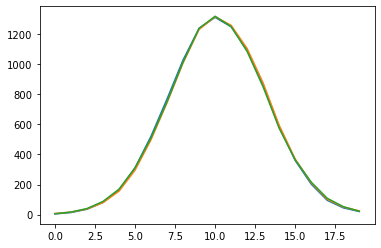

In [81]:
plt.plot( output_histograms[0,:])
plt.plot( output_histograms[1,:])
plt.plot( output_histograms[2,:])

In [82]:
with open( '%s/bootstrap-output-histograms.npy' % ( output_dir ), 'wb' ) as f :
    np.save( f, output_histograms )
    np.save( f, this_output_hist_binning )